<a href="https://colab.research.google.com/github/ahaditi/assignment-2/blob/main/BDA_project_Airline_Delay_Analysis_Final_Copy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install findspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pip install base-map

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement base-map (from versions: none)
ERROR: No matching distribution found for base-map


In [140]:
import findspark 
findspark.init() 
findspark.find() 
import pyspark 
findspark.find()

'/usr/local/lib/python3.8/dist-packages/pyspark'

In [141]:
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
conf = pyspark.SparkConf().setAppName('appName').setMaster('local')
#sc = pyspark.SparkContext(conf=conf)
spark = SparkSession(sc)

In [142]:
from pyspark.sql import SQLContext
from pyspark.sql.types import *
from pyspark.sql import Row
from pyspark.mllib.regression import LabeledPoint
from pyspark.sql.functions import udf
from pyspark.mllib.linalg import Vectors
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.param import Param, Params
from pyspark.mllib.classification import LogisticRegressionWithLBFGS, LogisticRegressionModel
from pyspark.mllib.regression import LabeledPoint
from pyspark.mllib.stat import Statistics
from pyspark.ml.feature import OneHotEncoder, StringIndexer
from pyspark.mllib.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from IPython.display import display
from ipywidgets import interact
import sys
import numpy as np
import pandas as pd
import time
import datetime
import matplotlib.pyplot as plt
import os.path
import pyarrow as pa
from pyarrow import csv
spark.conf.set("spark.sql.execution.arrow.enabled", "true")
%matplotlib inline

In [143]:
textFile = sc.textFile('/content/sample_data/2014Flightdata.csv')
textFileRDD = textFile.map(lambda x: x.split(','))
header = textFileRDD.first()
textRDD = textFileRDD.filter(lambda r: r != header)

In [145]:
def parse(r):
    try:
        x=Row(Year=int(r[0]),\
          Month=int(r[1]),\
          DayofMonth=int(r[2]),\
          DayOfWeek=int(r[3]),\
          DepTime=int(float(r[8])), \
          CRSDepTime=int(r[7]),\
          ArrTime=int(float(r[11])),\
          CRSArrTime=int(r[10]), \
          UniqueCarrier=r[4],\
          DepDelay=int(float(r[9])),\
          Origin=r[5],\
          Dest=r[6], \
          Distance=int(float(r[12])),\
          CarrierDelay=int(float(r[13])),\
          WeatherDelay=int(float(r[14])),\
          NASDelay= int(float(r[15])),\
          SecurityDelay=int(float(r[16])),\
          LateAircraftDelay=int(float(r[17])))  
    except:
        x=None  
    return x

rowRDD = textRDD.map(lambda r: parse(r)).filter(lambda r:r != None)
sqlContext = SQLContext(sc)
airline_df = sqlContext.createDataFrame(rowRDD)

In [146]:
airline_df = airline_df.withColumn('DepDelayed', airline_df['DepDelay']>15)

In [147]:
# define hour function to obtain hour of day
def hour_ex(x): 
    h = int(str(int(x)).zfill(4)[:2])
    return h

# register as a UDF 
sqlContext.udf.register("hour_ex_py",hour_ex, IntegerType())
f_udf = udf(hour_ex, IntegerType())

#CRSDepTime: scheduled departure time (local, hhmm)
airline_df = airline_df.withColumn('hour', f_udf(airline_df.CRSDepTime))
airline_df.registerTempTable("airlineDF")

In [148]:
airline_df.head(n=5)

[Row(Year=2014, Month=9, DayofMonth=11, DayOfWeek=4, DepTime=1324, CRSDepTime=1315, ArrTime=1431, CRSArrTime=1410, UniqueCarrier='OO', DepDelay=9, Origin='SLC', Dest='LAX', Distance=590, CarrierDelay=9, WeatherDelay=0, NASDelay=12, SecurityDelay=0, LateAircraftDelay=0, DepDelayed=False, hour=13),
 Row(Year=2014, Month=9, DayofMonth=18, DayOfWeek=4, DepTime=1320, CRSDepTime=1315, ArrTime=1425, CRSArrTime=1410, UniqueCarrier='OO', DepDelay=5, Origin='SLC', Dest='LAX', Distance=590, CarrierDelay=3, WeatherDelay=0, NASDelay=10, SecurityDelay=0, LateAircraftDelay=2, DepDelayed=False, hour=13),
 Row(Year=2014, Month=9, DayofMonth=7, DayOfWeek=7, DepTime=1415, CRSDepTime=1315, ArrTime=1520, CRSArrTime=1410, UniqueCarrier='OO', DepDelay=60, Origin='SLC', Dest='LAX', Distance=590, CarrierDelay=2, WeatherDelay=0, NASDelay=10, SecurityDelay=0, LateAircraftDelay=58, DepDelayed=True, hour=13),
 Row(Year=2014, Month=9, DayofMonth=28, DayOfWeek=7, DepTime=1418, CRSDepTime=1315, ArrTime=1517, CRSArrTi

In [149]:
cause_delay = sqlContext.sql("SELECT sum(WeatherDelay) Weather,sum(NASDelay) NAS,sum(SecurityDelay) Security,sum(LateAircraftDelay) lateAircraft,sum(CarrierDelay) Carrier\
                              FROM airlineDF ")

In [150]:
df_cause_delay = cause_delay.toPandas()
df_cause_delay.head()

,Weather,NAS,Security,lateAircraft,Carrier
0,448707,2043962,7538,3128854,2520337


In [151]:
groupedDelay = sqlContext.sql("SELECT Origin, count(*) conFlight,avg(DepDelay) delay \
                                FROM airlineDF \
                                GROUP BY Origin")

df_origin = groupedDelay.toPandas()
df_origin.sort_values('delay',ascending=0).head()

,Origin,conFlight,delay
220,PLN,2,247.5000
287,COD,2,242.0000
202,DVL,1,192.0000
289,CPR,2,179.5000
257,BGR,16,145.0625


In [152]:
df = pd.read_csv('/content/sample_data/airports.dat', index_col=0,\
names = ['name', 'city', 'country','IATA','ICAO','lat','lng','alt','TZone','DST','Tz','air','Ourair'], \
            header=0)
del df['air']
del df['Ourair']
df.head()

,name,city,country,IATA,ICAO,lat,lng,alt,TZone,DST,Tz
2,Madang Airport,Madang,Papua New Guinea,MAG,AYMD,-5.207080,145.789001,20,10,U,Pacific/Port_Moresby
3,Mount Hagen Kagamuga Airport,Mount Hagen,Papua New Guinea,HGU,AYMH,-5.826790,144.296005,5388,10,U,Pacific/Port_Moresby
4,Nadzab Airport,Nadzab,Papua New Guinea,LAE,AYNZ,-6.569803,146.725977,239,10,U,Pacific/Port_Moresby
5,Port Moresby Jacksons International Airport,Port Moresby,Papua New Guinea,POM,AYPY,-9.443380,147.220001,146,10,U,Pacific/Port_Moresby
6,Wewak International Airport,Wewak,Papua New Guinea,WWK,AYWK,-3.583830,143.669006,19,10,U,Pacific/Port_Moresby


In [153]:
df_airports = pd.merge(df_origin, df, left_on = 'Origin', right_on = 'IATA')
df_airports.head()

,Origin,conFlight,delay,name,city,country,IATA,ICAO,lat,lng,alt,TZone,DST,Tz
0,MSY,524,56.435115,Louis Armstrong New Orleans International Airport,New Orleans,United States,MSY,KMSY,29.993401,-90.258003,4,-6,A,America/Chicago
1,GEG,116,41.077586,Spokane International Airport,Spokane,United States,GEG,KGEG,47.619900,-117.533997,2376,-8,A,America/Los_Angeles
2,SNA,447,46.123043,John Wayne Airport-Orange County Airport,Santa Ana,United States,SNA,KSNA,33.675701,-117.867996,56,-8,A,America/Los_Angeles
3,BUR,92,41.032609,Bob Hope Airport,Burbank,United States,BUR,KBUR,34.200699,-118.359001,778,-8,A,America/Los_Angeles
4,GRR,446,60.616592,Gerald R. Ford International Airport,Grand Rapids,United States,GRR,KGRR,42.880798,-85.522797,794,-5,A,America/New_York


In [154]:
df_airports.sort_values('delay',ascending=0).head()

,Origin,conFlight,delay,name,city,country,IATA,ICAO,lat,lng,alt,TZone,DST,Tz
220,PLN,2,247.5000,Pellston Regional Airport of Emmet County Airport,Pellston,United States,PLN,KPLN,45.570900,-84.796700,721,-5,A,America/New_York
287,COD,2,242.0000,Yellowstone Regional Airport,Cody,United States,COD,KCOD,44.520199,-109.024002,5102,-7,A,America/Denver
202,DVL,1,192.0000,Devils Lake Regional Airport,Devils Lake,United States,DVL,KDVL,48.114201,-98.908798,1456,-6,A,America/Chicago
289,CPR,2,179.5000,Casper-Natrona County International Airport,Casper,United States,CPR,KCPR,42.908001,-106.463997,5350,-7,A,America/Denver
257,BGR,16,145.0625,Bangor International Airport,Bangor,United States,BGR,KBGR,44.807400,-68.828102,192,-5,A,America/New_York


In [155]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def zscore(x):
    return (x-np.average(x))/np.std(x)

In [156]:
import os
os.environ['PROJ_LIB'] = r'C:\Users\spl2s\anaconda3\pkgs\proj4-5.2.0-\
ha925a31_1\Library\share'

In [157]:
pip install Basemap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [158]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
from pylab import rcParams
%matplotlib inline

In [159]:
pip install basemap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Each marker is an airport.
Size of markers: Airport Traffic (larger means higher number of flights in year)
Color of markers: Average Flight Delay (Redder means longer delays)


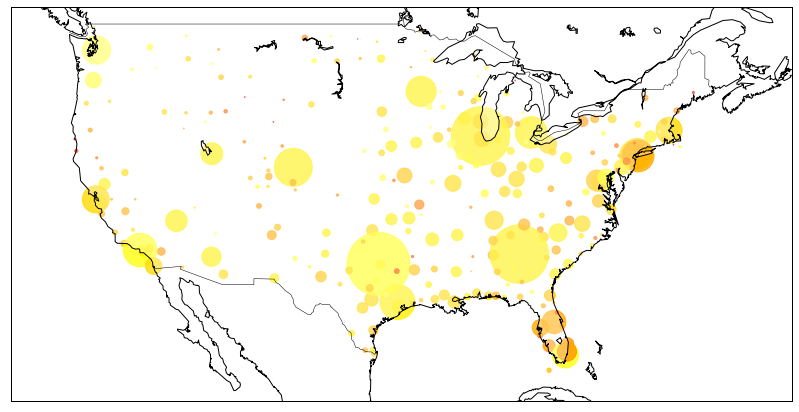

In [160]:
rcParams['figure.figsize'] = (14,10)


my_map = Basemap(projection='merc',
            resolution = 'l', area_thresh = 1000.0,
            llcrnrlon=-130, llcrnrlat=22, #min longitude (llcrnrlon) and latitude (llcrnrlat)
            urcrnrlon=-60, urcrnrlat=50) #max longitude (urcrnrlon) and latitude (urcrnrlat)

my_map.drawcoastlines()
my_map.drawcountries()
my_map.drawmapboundary()
my_map.fillcontinents(color = 'white', alpha = 0.3)
my_map.shadedrelief()

# To create a color map
colors = plt.get_cmap('hot')(np.linspace(0.0, 1.0, 30))
colors=np.flipud(colors)

#----- Scatter -------
countrange=max(df_airports['conFlight'])-min(df_airports['conFlight'])
al=np.array([sigmoid(x) for x in zscore(df_airports['delay'])])
xs,ys = my_map(np.asarray(df_airports['lng']), np.asarray(df_airports['lat']))
val=df_airports['conFlight']*4000.0/countrange

my_map.scatter(xs, ys,  marker='o', s= val, alpha = 0.8,color=colors[(al*20).astype(int)])

#----- Text -------
df_text=df_airports[(df_airports['conFlight']>60000) & (df_airports['IATA'] != 'HNL')]
xt,yt = my_map(np.asarray(df_text['lng']), np.asarray(df_text['lat']))
txt=np.asarray(df_text['IATA'])
zp=zip(xt,yt,txt)
for row in zp:
    #print zp[2]
    plt.text(row[0],row[1],row[2], fontsize=10, color='blue',)

print("Each marker is an airport.")
print("Size of markers: Airport Traffic (larger means higher number of flights in year)")
print("Color of markers: Average Flight Delay (Redder means longer delays)")

plt.show()

In [161]:
grp_rout_Delay = sqlContext.sql("SELECT Origin, Dest, count(*) traffic,avg(Distance) avgDist,\
                                    avg(DepDelay) avgDelay\
                                FROM airlineDF \
                                GROUP BY Origin,Dest")
rout_Delay = grp_rout_Delay.toPandas()
df_airport_rout1 = pd.merge(rout_Delay, df, left_on = 'Origin', right_on = 'IATA')
df_airport_rout2 = pd.merge(df_airport_rout1, df, left_on = 'Dest', right_on = 'IATA')
df_airport_rout = df_airport_rout2[["Origin","lat_x","lng_x","Dest","lat_y","lng_y",\
                                    "avgDelay", "traffic"]]
df_airport_rout.sort_values('avgDelay',ascending=0).head()

,Origin,lat_x,lng_x,Dest,lat_y,lng_y,avgDelay,traffic
541,PSP,33.829700,-116.507004,MSP,44.882000,-93.221802,562.5,2
494,COD,44.520199,-109.024002,DEN,39.861698,-104.672997,422.0,1
1769,IND,39.717300,-86.294403,SFO,37.618999,-122.375000,387.0,1
971,AVP,41.338501,-75.723396,ATL,33.636700,-84.428101,384.0,1
3702,JFK,40.639801,-73.778900,EGE,39.642601,-106.917999,367.2,5


Each line represents a route from the Origin to Destination airport.
The redder line, the higher probablity of delay.


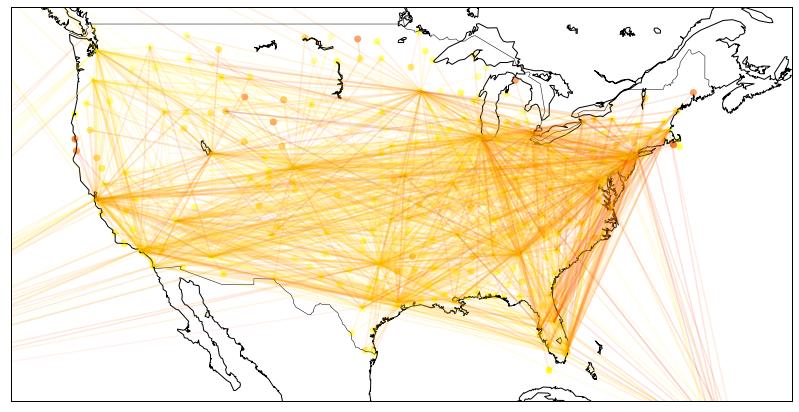

In [162]:
rcParams['figure.figsize'] = (14,10)


my_map = Basemap(projection='merc',
            resolution = 'l', area_thresh = 1000.0,
            llcrnrlon=-130, llcrnrlat=22, #min longitude (llcrnrlon) and latitude (llcrnrlat)
            urcrnrlon=-60, urcrnrlat=50) #max longitude (urcrnrlon) and latitude (urcrnrlat)

my_map.drawcoastlines()
my_map.drawcountries()
my_map.drawmapboundary()
my_map.fillcontinents(color = 'white', alpha = 0.3)
my_map.shadedrelief()

delay=np.array([sigmoid(x) for x in zscore(df_airports["delay"])])
colors = plt.get_cmap('hot')(np.linspace(0.0, 1.0, 40))
colors=np.flipud(colors)
xs,ys = my_map(np.asarray(df_airports['lng']), np.asarray(df_airports['lat']))
xo,yo = my_map(np.asarray(df_airport_rout['lng_x']), np.asarray(df_airport_rout['lat_x']))
xd,yd = my_map(np.asarray(df_airport_rout['lng_y']), np.asarray(df_airport_rout['lat_y']))

my_map.scatter(xs, ys,  marker='o',  alpha = 0.8,color=colors[(delay*20).astype(int)])


al=np.array([sigmoid(x) for x in zscore(df_airport_rout["avgDelay"])])
f=zip(xo,yo,xd,yd,df_airport_rout['avgDelay'],al)
for row in f:
    plt.plot([row[0],row[2]], [row[1],row[3]],'-',alpha=0.07, \
             color=colors[(row[5]*30).astype(int)] )
    

for row in zp:
    plt.text(row[0],row[1],row[2], fontsize=10, color='blue',)

print("Each line represents a route from the Origin to Destination airport.")
print("The redder line, the higher probablity of delay.")
    
plt.show()

In [163]:
Origin_Airport="SJC"
df_ORG = sqlContext.sql("SELECT * from airlineDF WHERE origin='"+ Origin_Airport+"'")
df_ORG.registerTempTable("df_ORG")
df_ORG.select('ArrTime','CRSArrTime','CRSDepTime',\
              'DayOfWeek','DayofMonth','DepDelay','DepTime','Dest').show(2)

/usr/local/lib/python3.8/dist-packages/pyspark/sql/dataframe.py:229: FutureWarning: Deprecated in 2.0, use createOrReplaceTempView instead.
  warnings.warn("Deprecated in 2.0, use createOrReplaceTempView instead.", FutureWarning)


+-------+----------+----------+---------+----------+--------+-------+----+
|ArrTime|CRSArrTime|CRSDepTime|DayOfWeek|DayofMonth|DepDelay|DepTime|Dest|
+-------+----------+----------+---------+----------+--------+-------+----+
|   2025|      1710|      1338|        1|         8|     215|   1713| DEN|
|   1051|      1026|       655|        6|         6|      40|    735| DEN|
+-------+----------+----------+---------+----------+--------+-------+----+
only showing top 2 rows



In [164]:
print("total flights from this ariport: " + str(df_ORG.count()))

total flights from this ariport: 487


In [165]:
grp_carr = sqlContext.sql("SELECT  UniqueCarrier,month, avg(DepDelay) avgDelay from df_ORG \
                            WHERE DepDelayed=True \
                            GROUP BY UniqueCarrier,month")
s = grp_carr.toPandas()

In [166]:
ps = s.pivot(index='month', columns='UniqueCarrier', values='avgDelay')[['AA','UA','US']]

Text(0.5, 1.0, 'How much delay does each carrier has in each month?')

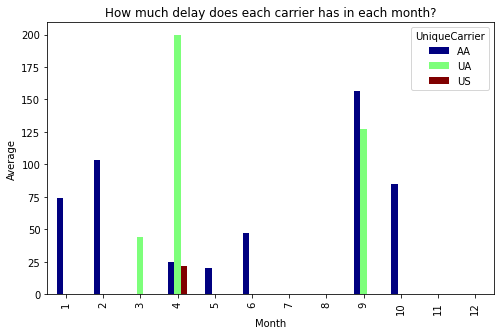

In [188]:
rcParams['figure.figsize'] = (8,5)
ps.plot(kind='bar', colormap='jet');
plt.xlabel('Month')
plt.ylabel('Average')
plt.title('How much delay does each carrier has in each month?')

In [167]:
hour_grouped = df_ORG.filter(df_ORG['DepDelayed']).select('DayOfWeek','hour','DepDelay').groupby('DayOfWeek','hour').mean('DepDelay')

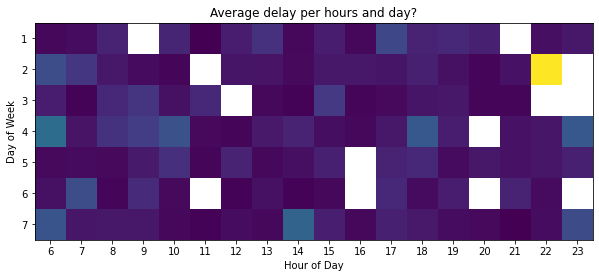

In [168]:
rcParams['figure.figsize'] = (10,5)
dh = hour_grouped.toPandas()
c = dh.pivot('DayOfWeek','hour')
X = c.columns.levels[1].values
Y = c.index.values
Z = c.values
plt.xticks(range(0,24), X)
plt.yticks(range(0,7), Y)
plt.xlabel('Hour of Day')
plt.ylabel('Day of Week')
plt.title('Average delay per hours and day?')
plt.imshow(Z)

In [169]:
Origin_Airport="SJC"
df_ORG=sqlContext.sql("SELECT * from airlineDF WHERE Origin = '"+Origin_Airport+"'")
df_ORG.registerTempTable("df_ORG")

In [170]:
#feature selction
df_model=df_ORG
stringIndexer1 = StringIndexer(inputCol="Origin", outputCol="originIndex")
model_stringIndexer = stringIndexer1.fit(df_model)
indexedOrigin = model_stringIndexer.transform(df_model)
encoder1 = OneHotEncoder(dropLast=False,inputCol="originIndex", outputCol="originVec")
ohe = encoder1.fit(indexedOrigin)
df_model = ohe.transform(indexedOrigin)

In [171]:
assembler = VectorAssembler(
    inputCols = ['Year','Month','DayofMonth','DayOfWeek','hour','Distance','originVec'],
    outputCol = "features")
output = assembler.transform(df_model)

In [172]:
from pyspark.mllib import linalg as mllib_linalg
from pyspark.ml import linalg as ml_linalg
from pyspark.sql.functions import col
def as_old(v):
    if isinstance(v, ml_linalg.SparseVector):
        return mllib_linalg.SparseVector(v.size, v.indices, v.values)
    if isinstance(v, ml_linalg.DenseVector):
        return mllib_linalg.DenseVector(v.values)
    raise ValueError("Unsupported type {0}".format(type(v)))
airlineRDD=output.select(col("DepDelayed").alias("label"), col("features"))\
            .rdd\
            .map(lambda row: LabeledPoint(row.label, as_old(row.features)))

In [173]:
airlineRDD.take(2)

[LabeledPoint(1.0, [2014.0,9.0,8.0,1.0,13.0,948.0,1.0]),
 LabeledPoint(1.0, [2014.0,9.0,6.0,6.0,6.0,948.0,1.0])]

In [174]:
#  Spliting dataset into train and test dtasets
trainRDD,testRDD=airlineRDD.randomSplit([0.7,0.3])

In [175]:
# Build the model
model = LogisticRegressionWithLBFGS.train(trainRDD)

In [176]:
# Evaluating the model on testing data
labelsAndPreds = testRDD.map(lambda p: (p.label, model.predict(p.features)))
labelsAndPreds.take(2)

[(1.0, 1), (1.0, 1)]

In [177]:

trainErr = labelsAndPreds.filter(lambda lp: lp[0] != lp[1]).count() / float(testRDD.count())
print("Training Error = " + str(trainErr))

Training Error = 0.24836601307189543


In [178]:
testRDD.take(10)

[LabeledPoint(1.0, [2014.0,9.0,8.0,1.0,13.0,948.0,1.0]),
 LabeledPoint(1.0, [2014.0,9.0,1.0,1.0,10.0,308.0,1.0]),
 LabeledPoint(1.0, [2014.0,9.0,1.0,1.0,11.0,308.0,1.0]),
 LabeledPoint(1.0, [2014.0,9.0,16.0,2.0,15.0,342.0,1.0]),
 LabeledPoint(1.0, [2014.0,9.0,16.0,2.0,19.0,342.0,1.0]),
 LabeledPoint(1.0, [2014.0,9.0,17.0,3.0,20.0,296.0,1.0]),
 LabeledPoint(1.0, [2014.0,9.0,17.0,3.0,14.0,386.0,1.0]),
 LabeledPoint(0.0, [2014.0,9.0,17.0,3.0,19.0,308.0,1.0]),
 LabeledPoint(1.0, [2014.0,9.0,17.0,3.0,20.0,697.0,1.0]),
 LabeledPoint(1.0, [2014.0,9.0,19.0,5.0,18.0,296.0,1.0])]

In [179]:
def conf(r):
    if r[0] == r[1] ==1: x= 'TP'
    if r[0] == r[1] ==0: x= 'TN'
    if r[0] == 1 and  r[1] ==0: x= 'FN'
    if r[0] == 0 and  r[1] ==1: x= 'FP'
    return (x)
acc1 = labelsAndPreds.map(lambda vp: ((vp[1], vp[0]), 1)).reduceByKey(lambda a, b: a + b).take(5)
acc = [(conf(x[0]),x[1]) for x in acc1]

In [180]:
for x in range(len(acc)): 
    print (acc[x])

('TN', 5)
('FN', 37)
('TP', 110)
('FP', 1)


In [181]:
TP=TN=FP=FN=0.0
for x in acc: 
    if x[0]=='TP': TP= x[1]
    if x[0]=='TN': TN= x[1]
    if x[0]=='FP': FP= x[1]
    if x[0]=='FN': FN= x[1]
eps = sys.float_info.epsilon
Accuracy = (TP+TN) / (TP + TN+ FP+FN+eps) 
print("Model Accuracy for SJC:")
print(float(Accuracy*100))

Model Accuracy for SJC:
75.16339869281046
